In [1]:
import sys
# Add paths to Python environment
sys.path.append('/home/fonta42/Desktop/masters-degree/data/vess-map')
sys.path.append('/home/fonta42/Desktop/masters-degree/MedSAM/')
sys.path.append('/home/fonta42/Desktop/masters-degree/MedSAM/utils')


import os
import torch
from segment_anything import sam_model_registry
from utils.demo import BboxPromptDemo
from vess_map_dataset import VessMapDataset

In [2]:
# Dataset paths
IMAGE_DIR = '/home/fonta42/Desktop/masters-degree/data/vess-map/images'
MASK_DIR = '/home/fonta42/Desktop/masters-degree/data/vess-map/labels'
SKELETON_DIR = '/home/fonta42/Desktop/masters-degree/data/vess-map/skeletons'

# Image file paths for demo
IMAGE_DIRECTORY = "/home/fonta42/Desktop/masters-degree/data/vess-map/png_images"

# Device for computation (CUDA / GPU)
DEVICE = "cuda:0"

# Image size for dataset
IMAGE_SIZE = 256

In [3]:
# Dataset Setup
vess_dataset = VessMapDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    skeleton_dir=SKELETON_DIR,
    image_size=IMAGE_SIZE,
    apply_transform=True
)

train_loader, test_loader = vess_dataset.vess_map_dataloader(batch_size=80, train_size=0.8)


In [4]:
# Model Loading

# Paths for the SAM model
MEDSAM_CKPT_PATH = "/home/fonta42/Desktop/masters-degree/experiments/med-sam/medsam_finetuned_vessels_best.pth"
MEDSAM_MODEL_PATH = "/home/fonta42/Desktop/masters-degree/MedSAM/work_dir/MedSAM/medsam_vit_b.pth"

sam_state_dict = torch.load(MEDSAM_CKPT_PATH)
print(f"Loaded model keys: {sam_state_dict['model'].keys()}")

medsam_model = sam_model_registry['vit_b'](checkpoint=MEDSAM_MODEL_PATH)
fine_tuned_medsam_model = medsam_model.to(DEVICE)
fine_tuned_medsam_model.load_state_dict(sam_state_dict['model'])
fine_tuned_medsam_model.eval()

/tmp/ipykernel_8541/4096093469.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sam_state_dict = torch.load(MEDSAM_CKPT_PATH)


Loaded model keys: odict_keys(['image_encoder.pos_embed', 'image_encoder.patch_embed.proj.weight', 'image_encoder.patch_embed.proj.bias', 'image_encoder.blocks.0.norm1.weight', 'image_encoder.blocks.0.norm1.bias', 'image_encoder.blocks.0.attn.rel_pos_h', 'image_encoder.blocks.0.attn.rel_pos_w', 'image_encoder.blocks.0.attn.qkv.weight', 'image_encoder.blocks.0.attn.qkv.bias', 'image_encoder.blocks.0.attn.proj.weight', 'image_encoder.blocks.0.attn.proj.bias', 'image_encoder.blocks.0.norm2.weight', 'image_encoder.blocks.0.norm2.bias', 'image_encoder.blocks.0.mlp.lin1.weight', 'image_encoder.blocks.0.mlp.lin1.bias', 'image_encoder.blocks.0.mlp.lin2.weight', 'image_encoder.blocks.0.mlp.lin2.bias', 'image_encoder.blocks.1.norm1.weight', 'image_encoder.blocks.1.norm1.bias', 'image_encoder.blocks.1.attn.rel_pos_h', 'image_encoder.blocks.1.attn.rel_pos_w', 'image_encoder.blocks.1.attn.qkv.weight', 'image_encoder.blocks.1.attn.qkv.bias', 'image_encoder.blocks.1.attn.proj.weight', 'image_encoder.

/home/fonta42/Desktop/masters-degree/MedSAM/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.de

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [5]:
# Image Loader
image_file_paths = []

for file_name in os.listdir(IMAGE_DIRECTORY):
    full_path = os.path.join(IMAGE_DIRECTORY, file_name)
    if os.path.isfile(full_path) and file_name.lower().endswith('.png'):
        image_file_paths.append(full_path)

print(f"Found {len(image_file_paths)} image files in {IMAGE_DIRECTORY}.")

Found 100 image files in /home/fonta42/Desktop/masters-degree/data/vess-map/png_images.


Button(description='clear', style=ButtonStyle())

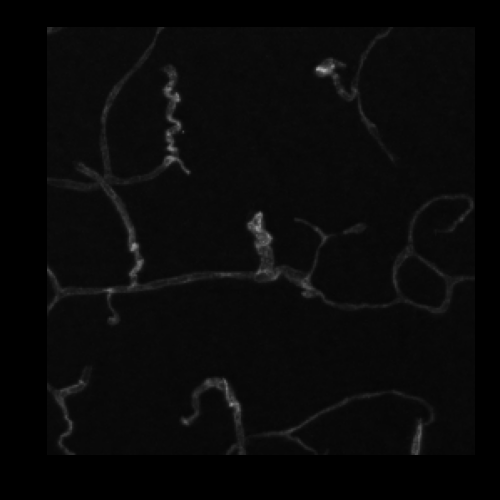

Button(description='save', style=ButtonStyle())

In [25]:
# BBox Prompt Visualization
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(fine_tuned_medsam_model)
bbox_prompt_demo.show(image_file_paths[99])